In [16]:
import sys
import time
import numpy as np
import os.path as osp
import tensorflow as tf
import matplotlib.pyplot as plt

from tf_lab.fundamentals.utils import set_visible_GPUs, reset_tf_graph

import tf_lab.point_clouds.in_out as pio
from tf_lab.point_clouds.in_out import PointCloudDataSet, write_model_ids_of_datasets
from tf_lab.point_clouds.point_net_ae import PointNetAutoEncoder
from tf_lab.point_clouds.autoencoder import Configuration as Conf
import tf_lab.point_clouds.encoders_decoders as enc_dec


from tf_lab.autopredictors.scripts.helper import shape_net_category_to_synth_id, match_incomplete_to_complete_data
from tf_lab.autopredictors.scripts import loading_virt_scan_data as vscan

from tf_lab.autopredictors.plotting import plot_original_pclouds_vs_reconstructed, \
                                           plot_train_val_test_curves, plot_reconstructions_at_epoch, \
                                           plot_interpolations
from tf_lab.autopredictors.evaluate import eval_model, read_saved_epochs
                                                  
from tf_lab.autopredictors.exploration import latent_embedding_of_entire_dataset, find_neighbors, write_out_neighborhoods

from general_tools.in_out.basics import create_dir, delete_files_in_directory, files_in_subdirs
from general_tools.simpletons import select_first_last_and_k

from geo_tool import Point_Cloud

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
experiment_name = '3_2_fc_decoder_2048pts_vscan_train'
do_training = False
do_plotting = True
first_time_running = False
load_model = True

class_type = raw_input('Give me the class type.\n').lower()
class_syn_id = shape_net_category_to_synth_id()[class_type]

Give me the class type.
chair


In [4]:
seed = 42
np.random.seed(seed)
tf.set_random_seed(seed)

top_data_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/'
full_pclouds_path = osp.join(top_data_dir, 'ShapeNetPointClouds/from_manifold_meshes/2048/', class_syn_id)

train_dir = osp.join(top_data_dir, 'OUT/models/vanilla_ae/', class_syn_id)
train_dir = osp.join(train_dir, experiment_name)
create_dir(train_dir)

'/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/models/vanilla_ae/03001627/3_2_fc_decoder_2048pts_vscan_train'

In [21]:
full_file_names = pio.load_filenames_of_input_data(full_pclouds_path)
full_pclouds, full_model_names, full_syn_ids = pio.load_crude_point_clouds(file_names=full_file_names, n_threads=20)
print '%d files containing complete point clouds were found.' % (len(full_pclouds), )

train_id_file = '/orions4-zfs/projects/lins2/Panos_Space/DATA/From_Matthias/shapenet_all-train.txt'
mask = vscan.mask_of_permissible(full_model_names, train_id_file, class_syn_id)
train_data = PointCloudDataSet(full_pclouds[mask], labels=full_model_names[mask])

test_id_file = '/orions4-zfs/projects/lins2/Panos_Space/DATA/From_Matthias/shapenet_all-test.txt'
mask = vscan.mask_of_permissible(full_model_names, test_id_file, class_syn_id)
test_data = PointCloudDataSet(full_pclouds[mask], labels=full_model_names[mask])

6778 files containing complete point clouds were found.


In [9]:
if load_model:
    conf = Conf.load(osp.join(train_dir, 'configuration'))
    print conf
else:

    n_input = [2048, 3]
    
    decoder_args = {'layer_sizes': [1024, np.prod(n_input)], 
                    'non_linearity': tf.nn.tanh
                   }

    conf = Conf(
                n_input = n_input,
                training_epochs = 1000,
                batch_size = 50,
                loss = 'chamfer',
                train_dir = train_dir,
                loss_display_step = 1,
                saver_step = 10,
                learning_rate = 0.00002,
                saver_max_to_keep = 100,
                gauss_augment = {'mu': 0, 'sigma': 0.02},
                encoder = enc_dec.encoder_with_convs_and_symmetry,
                decoder = enc_dec.decoder_with_fc_only,
                decoder_args = decoder_args,
               )

    conf.experiment_name = experiment_name
    conf.save(osp.join(conf.train_dir, 'configuration'))

                    batch_size: 50
                         debug: False
                       decoder: decoder_with_fc_only
                  decoder_args: {'non_linearity': <function tanh at 0x7f68b5532938>, 'layer_sizes': [1024, 6144]}
                       encoder: encoder_with_convs_and_symmetry
                  encoder_args: {}
               experiment_name: 3_2_fc_decoder_2048pts_vscan_train
                 gauss_augment: {'mu': 0, 'sigma': 0.02}
                  is_denoising: False
               latent_vs_recon: 1.0
                 learning_rate: 2e-05
                          loss: chamfer
             loss_display_step: 1
                       n_input: [2048, 3]
                           n_z: None
             saver_max_to_keep: 100
                    saver_step: 10
                     train_dir: /orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/models/vanilla_ae/03001627/3_2_fc_decoder_2048pts_vscan_train
               training_epochs: 1000
                     

In [22]:
reset_tf_graph()
set_visible_GPUs([3])
ae = PointNetAutoEncoder(experiment_name, conf)

if load_model:
    saved_epochs = read_saved_epochs(conf.train_dir)
    ae.restore_model(train_dir, saved_epochs[-1], verbose=True)

if do_training:
    ae.train(train_data, conf)

Model restored in epoch 1600.


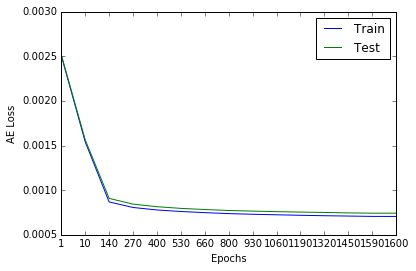

In [23]:
if do_plotting:
    saved_epochs = read_saved_epochs(conf.train_dir)
    plot_epochs = select_first_last_and_k(saved_epochs, 13)
    stats = eval_model(ae, conf, [train_data, test_data], epochs=plot_epochs)
    top_save_dir = osp.join(conf.train_dir, 'model_evaluation')
    plot_train_val_test_curves(stats, top_save_dir, has_validation=False, best_epoch=None, show=True)        
    
    last_epoch = saved_epochs[-1]
    save_dir = osp.join(top_save_dir, 'train_images_epoch_' + str(last_epoch))    
    plot_reconstructions_at_epoch(last_epoch, ae, train_data, conf, save_dir=save_dir, max_plot=100)    
    save_dir = osp.join(top_save_dir, 'test_images_epoch_' + str(last_epoch))
    plot_reconstructions_at_epoch(last_epoch, ae, test_data, conf, save_dir=save_dir, max_plot=100)

## Check Latent neighborhoods

In [24]:
print train_data.num_examples
print test_data.num_examples

tr_feed, tr_latent, tr_labels = latent_embedding_of_entire_dataset(train_data, ae, conf)
te_feed, te_latent, te_labels = latent_embedding_of_entire_dataset(test_data, ae, conf)

5000
1000


In [26]:
neighbors, distances = find_neighbors(tr_latent)
write_out_neighborhoods('train_10_neighbs.txt', tr_labels, neighbors, distances)

neighbors, distances = find_neighbors(tr_latent, te_latent)
write_out_neighborhoods('test_10_neighbs.txt', tr_labels, neighbors, distances, Y_labels=te_labels)

In [25]:
# # Visualize the neighborhoods.
# c = 1
# for f, n, d in zip(te_feed, neighbors, distances):    
#     Point_Cloud(points=f).plot()
#     npc = tr_labels[n]
    
#     id0 = np.where(npc[0] == full_model_names)[0][0]
#     Point_Cloud(points=full_pclouds[id0]).plot(in_u_sphere=True)
#     print d[0]
                                    
#     id1 = np.where(npc[1] == full_model_names)[0][0]
#     Point_Cloud(points=full_pclouds[id1]).plot(in_u_sphere=True)
#     print d[1]
#     raw_input('')

    



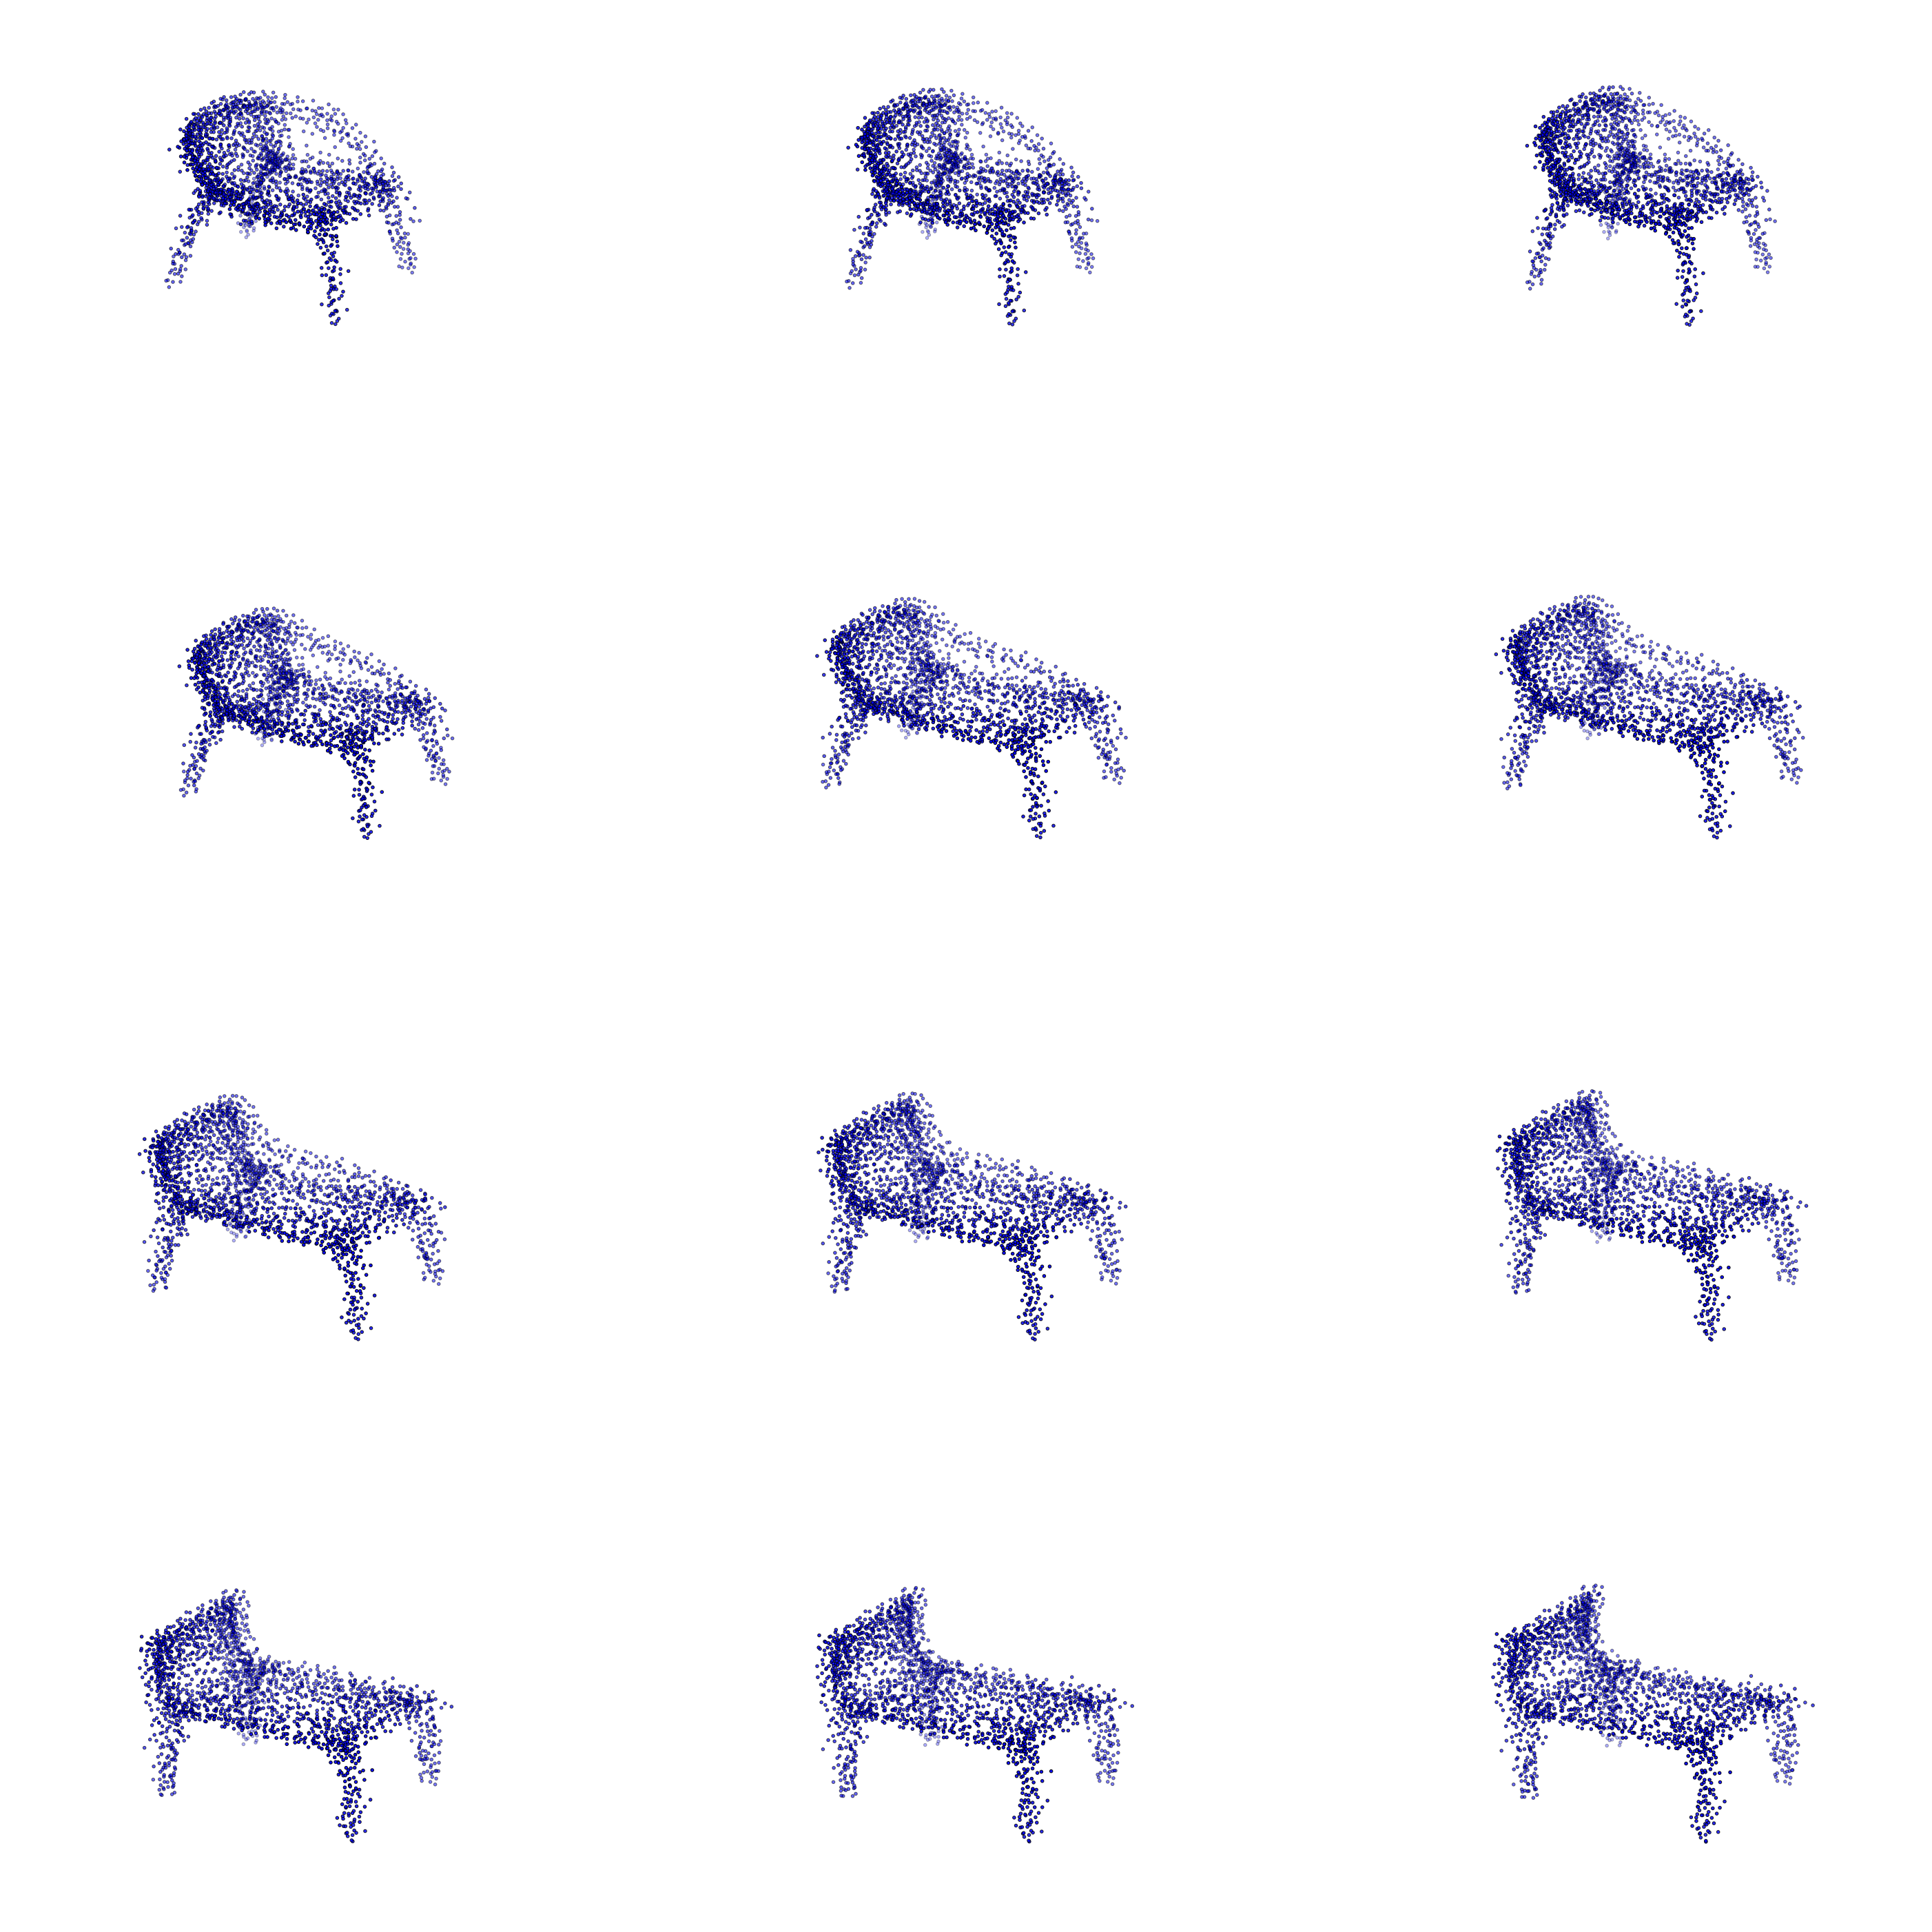

In [13]:
x, y = test_data.next_batch(2)[0]
interclouds = ae.interpolate(x, y, 10)
plot_interpolations(interclouds, [4,3]);